In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/frankmuci/code/frankmuci/venezuela_fx/venezuela_fx/data/working_df.csv')

In [3]:
df.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

In [4]:
df['Date'] = pd.to_datetime(df['Date'] )

In [5]:
df.set_index('Date', inplace=True)

In [6]:
log_cols = ['Money_Supply_M0', 'Money_Supply_M1', 'Money_Supply_M2', 'Money_Supply_M3', 'Central_Bank_Balance_Sheet', 'Private_Sector_Credit', 'Consumer_Price_Index_CPI', 'CPI_Transportation', 'Banks_Balance_Sheet', 'Dolartoday', 'Stock_Market']

for col in log_cols:
    df[col] = np.log(df[col])

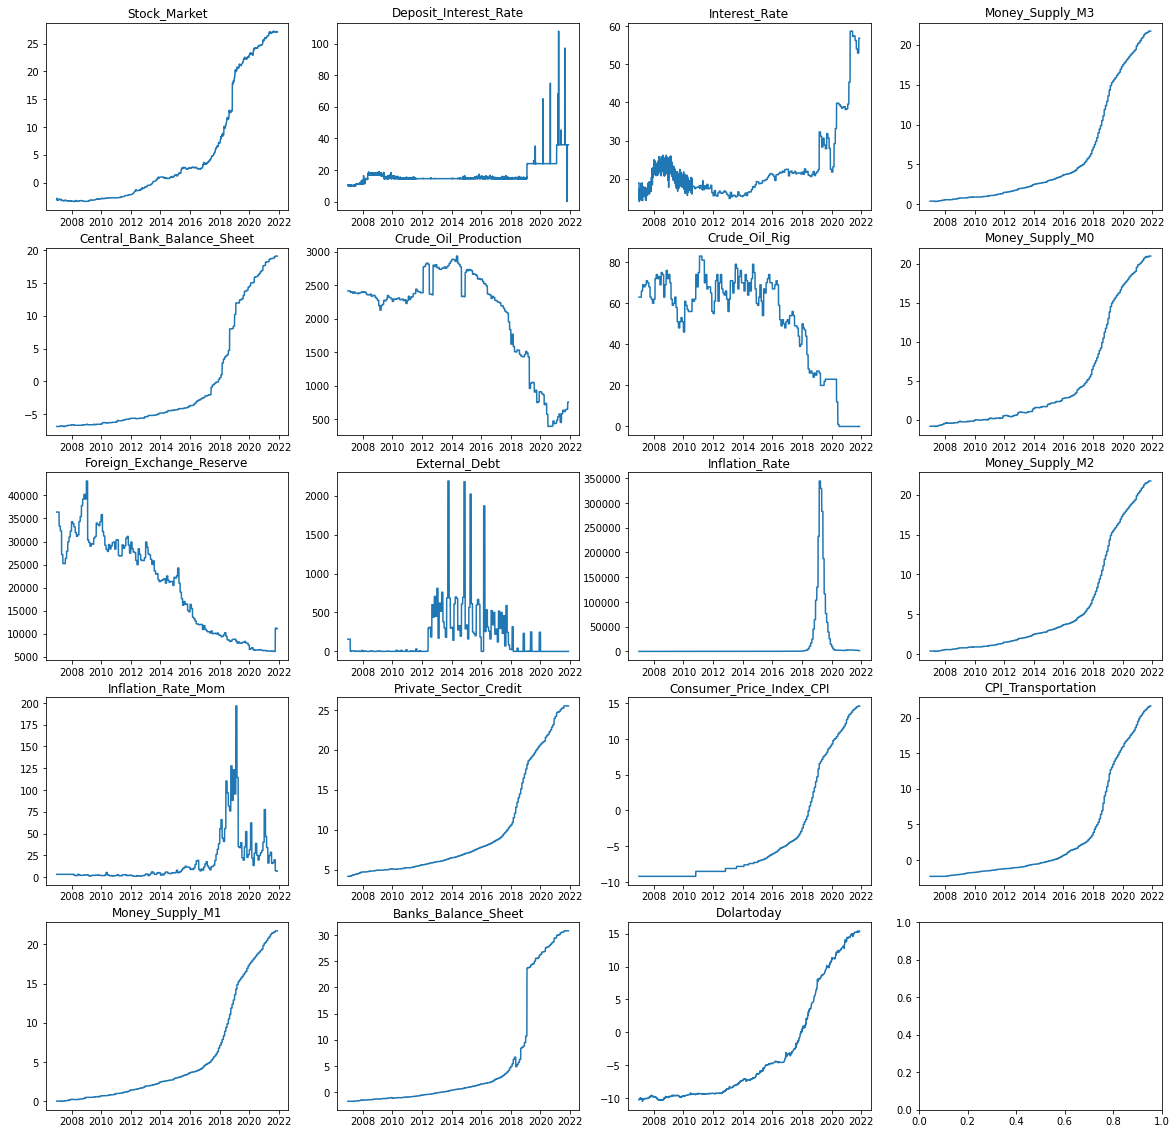

In [7]:
fig, axs = plt.subplots(5,4, figsize=(20,20))
axs = axs.flatten()
for idx, col in enumerate(list(df.columns)):
#     axs[idx].plot(df.resample('m').first()[col])
    axs[idx].plot(df[col])
    axs[idx].set_title(col)

## Select Features, Train Test Split

In [8]:
# SELECT FEATURES
# relevant_cols = ['Dolartoday', 'Money_Supply_M0', 'Money_Supply_M1', 'Money_Supply_M2', 'Money_Supply_M3', 'Stock_Market']
relevant_cols = ['Dolartoday', 'Stock_Market']
df = df[relevant_cols]
column_count = len(relevant_cols)

In [9]:
# TRAIN TEST SPLIT
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Imports and Code for Windowing 

In [10]:
import tensorflow as tf

2021-11-24 16:20:20.406532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 16:20:20.406595: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, 
                 val_df=val_df, test_df=test_df, label_columns=['Dolartoday']):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [12]:
window_size = 65
distance = 30
window = WindowGenerator(window_size, 1, distance)

## The model

In [13]:
# Inspect Shape of Data Samples
x_sample, y_sample = next(iter(window.train))
print(x_sample.shape)
print(y_sample.shape)

(32, 65, 2)
(32, 1, 1)


2021-11-24 16:20:21.848671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-24 16:20:21.848717: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 16:20:21.848736: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-SBD4PR3): /proc/driver/nvidia/version does not exist
2021-11-24 16:20:21.848997: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, Normalization, Masking, GRU, Dropout, LSTM

def init_model():
    model = Sequential()
    model.add(GRU(units=2, activation='tanh', input_shape=(window_size,column_count), return_sequences=True))
    model.add(GRU(units=2, activation='tanh'))
    model.add(Dense(5, activation="relu"))
    model.add(Dense(1, activation="linear"))
    
    model.compile(loss='mae', optimizer='rmsprop', metrics=['mape', 'mse', 'mae'])
    return model

In [15]:
test_model = init_model()

In [16]:
test_model.fit(window.train)

116/116 [==============================] - 9s 54ms/step - loss: 7.4042 - mape: 91.5505 - mse: 59.4716 - mae: 7.4042


In [17]:
predictions = test_model.predict(window.test)

In [18]:
series_pred = pd.Series(predictions[:, 0])
series_pred.index = test_df.iloc[94:].index

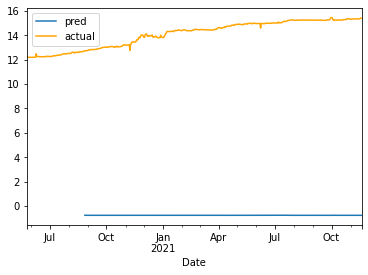

In [19]:
series_pred.plot(label = 'pred')
test_df['Dolartoday'].plot(label = 'actual', color = 'orange')
plt.legend()